# Homework 3. Dense Prediction (50 points)
---
In this part, you will study a problem of segmentation. The goal of this assignment is to study, implement, and compare different components of dense prediction models, including **data augmentation**, **backbones**, **classifiers** and **losses**.

This assignment will require training multiple neural networks, therefore it is advised to use a **GPU** accelerator.

<font color='red'>**In this task, it is obligatory to provide accuracy plots on the training and validation datasets obtained during training, as well as examples of the work of each of the models on the images. Without plots, your work will get 0 points. Writing a report is just as important as writing code.**</font>

**<font color='red'>Before the submission please convert your notebook to .py file and check that it runs correctly. How to get .py file in Colab: File -> Download -> Download .py**

In [ ]:
# !pip install -U gdown
!pip install pytorch_lightning

In [ ]:
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'tiny-imagenet-2022.zip' is.

# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Colab Notebooks/SK DL 2022/HW2")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.append(str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

In [ ]:
AUX_DATA_ROOT

In [ ]:
# pass a python variable to console in brckets {}
!ls {'"%s"' % AUX_DATA_ROOT}

In [ ]:
# Uncomment and run if in Colab
!mkdir datasets
!cp '{AUX_DATA_ROOT}/tiny-floodnet-challenge.tar.gz' datasets/tiny-floodnet-challenge.tar.gz
!tar -xzf datasets/tiny-floodnet-challenge.tar.gz -C datasets
!rm datasets/tiny-floodnet-challenge.tar.gz

In [ ]:
!ls datasets/tiny-floodnet-challenge

## Dataset

We will use a simplified version of a [FloodNet Challenge](http://www.classic.grss-ieee.org/earthvision2021/challenge.html).

Compared to the original challenge, our version doesn't have difficult (and rare) "flooded" labels, and the images are downsampled

<img src="https://i.imgur.com/RZuVuVp.png" />

## Assignments and grading


- **Part 1. Code**: fill in the empty gaps (marked with `#TODO`) in the code of the assignment (34 points):
    - `dataset` -- 4 points
    - `model` -- 20 points
    - `loss` -- 8 points
    - `train` -- 2 points
- **Part 2. Train and benchmark** the performance of the required models (6 points):
    - All 6 checkpoints are provided -- 3 points
    - Checkpoints have > 0.5 accuracy -- 3 points
- **Part 3. Report** your findings (10 points)
    - Each task -- 2.5 points

- **Total score**: 50 points.

For detailed grading of each coding assignment, please refer to the comments inside the files. Please use the materials provided during a seminar and during a lecture to do a coding part, as this will help you to further familiarize yourself with PyTorch. Copy-pasting the code from Google Search will get penalized.

In part 2, you should upload all your pre-trained checkpoints to your personal Google Drive, grant public access and provide a file ID, following the intructions in the notebook.

Note that for each task in part 3 to count towards your final grade, you should complete the corresponding tasks in part 2.

For example, if you are asked to compare Model X and Model Y, you should provide the checkpoints for these models in your submission, and their accuracies should be above minimal threshold.

## Part 1. Code


### `dataset`
**TODO: implement and apply data augmentations**

You'll need to study a popular augmentations library: [Albumentations](https://albumentations.ai/), and implement the requested augs. Remember that geometric augmentations need to be applied to both images and masks at the same time, and Albumentations has [native support](https://albumentations.ai/docs/getting_started/mask_augmentation/) for that.

In [1]:
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from torchvision.transforms import ToTensor
import os
from PIL import Image
import numpy as np
import torch
import cv2

MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

class UnNormalize:
    
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

class FloodNet(Dataset):
    """
    Labels semantic:
    0: Background, 1: Building, 2: Road, 3: Water, 4: Tree, 5: Vehicle, 6: Pool, 7: Grass
    """
    def __init__(
        self,
        data_path: str,
        phase: str,
        augment: bool,
        img_size: int,
    ):
        self.num_classes = 2
        self.data_path = data_path
        self.phase = phase
        self.augment = augment
        self.img_size = img_size

        self.items = [
            filename.split('.')[0]
            for filename in os.listdir(f'{data_path}/{phase}/image')
            if len(filename.split('.')[0]) > 0
        ]
        
        # TODO: implement augmentations (3.5 points)
        if augment:
            # TODO:
            # Random resize
            # Random crop (within image borders, output size = img_size)
            # Random rotation
            # Random horizontal and vertical Flip
            # Random color augmentation
            self.transform = A.Compose([
                A.RandomScale(
                    p=0.5,
                ),
                A.RandomCrop(
                    width=self.img_size,
                    height=self.img_size,
                    p=1.,
                ),
                A.RandomRotate90(
                    p=0.5,
                ),
                A.VerticalFlip(
                    p=0.5,
                ),
                A.HorizontalFlip(
                    p=0.5,
                ),
                A.ColorJitter(
                    brightness=0.2,
                    contrast=0.2,
                    p=0.5,
                ),
                A.Normalize(
                    mean=MEAN,
                    std=STD,
                ),
            ])

        else:
            # TODO: random crop to img_size
            self.transform = A.Compose([
                A.RandomCrop(
                    width=self.img_size,
                    height=self.img_size,
                    p=1.,
                ),
                A.Normalize(
                    mean=MEAN,
                    std=STD,
                ),
            ])
            
        self.base_tf = A.Compose([
            A.Resize(
                width=self.img_size,
                height=self.img_size,
                p=1.,
            ),
            A.Normalize(
                mean=MEAN,
                std=STD,
            ),
        ])
        
        self.to_tensor = ToTensor()

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        image = np.asarray(Image.open(f'{self.data_path}/{self.phase}/image/{self.items[index]}.jpg'))
        mask = np.asarray(Image.open(f'{self.data_path}/{self.phase}/mask/{self.items[index]}.png'))
        
        if self.phase == 'train':
            # TODO: apply transform to both image and mask (0.5 points)

            transformed = self.transform(
                image=image,
                mask=mask,
            )

            image = transformed['image']
            mask = transformed['mask']
        else:
            
            transformed = self.base_tf(
                image=image,
                mask=mask,
            )

            image = transformed['image']
            mask = transformed['mask']
            
        image = self.to_tensor(image.copy())
        mask = torch.from_numpy(mask.copy()).long()

        if self.phase == 'train':
            assert isinstance(image, torch.FloatTensor) and image.shape == (3, self.img_size, self.img_size)
            assert isinstance(mask, torch.LongTensor) and mask.shape == (self.img_size, self.img_size)

        return image, mask

### `model`
**TODO: Implement the required models.**

Typically, all segmentation networks consist of an encoder and decoder. Below is a scheme for a popular DeepLab v3 architecture:

<img src="https://i.imgur.com/cdlkxvp.png" />

The encoder consists of a convolutional backbone, typically with extensive use of convs with dilations (atrous convs) and a head, which helps to further boost the receptive field. As you can see, the general idea for the encoders is to have as big of a receptive field, as possible.

The decoder either does upsampling with convolutions (similarly to the scheme above, or to UNets), or even by simply interpolating the outputs of the encoder.

In this assignment, you will need to implement **UNet** and **DeepLab** models. Example UNet looks like this:

<img src="https://i.imgur.com/uVdcE4e.png" />

For **DeepLab** model we will have three variants for backbones: **ResNet18**, **VGG11 (with BatchNorm)**, and **MobileNet v3 (small).** Use `torchvision.models` to obtain pre-trained versions of these backbones and simply extract their convolutional parts. To familiarize yourself with **MobileNet v3** model, follow this [link](https://paperswithcode.com/paper/searching-for-mobilenetv3).

We will also use **Atrous Spatial Pyramid Pooling (ASPP)** head. Its scheme can be seen in the DeepLab v3 architecture above. ASPP is one of the blocks which greatly increases the spatial size of the model, and hence boosts the model's performance. For more details, you can refer to this [link](https://paperswithcode.com/method/aspp).

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models

class DoubleBlock(nn.Module):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        middle_channels: int=None,
        dropout: bool=False,
        p: float=0.2,
    ) -> None:

        super().__init__()

        if middle_channels is None:
            middle_channels = out_channels

        self.first_step = nn.Sequential(
            nn.Dropout(p) if dropout else nn.Identity(),
            nn.Conv2d(
                in_channels,
                middle_channels,
                kernel_size=(3, 3),
                padding=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
        )
        self.second_step = nn.Sequential(
            nn.Conv2d(
                middle_channels,
                out_channels,
                kernel_size=(3, 3),
                padding=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(
        self,
        x: torch.Tensor,
    ) -> torch.Tensor:

        x = self.first_step(x)
        x = self.second_step(x)

        return x

class Encoder(nn.Module):

    def __init__(
        self,
        channels: list,
        max_channels: int,
    ) -> None:

        super().__init__()
        
        last_or_not = lambda i, length: True if i == length - 1 else False

        self.blocks = nn.ModuleList([
            DoubleBlock(
                in_channels=channels[i],
                out_channels=channels[i + 1],
                middle_channels=max_channels if last_or_not(i, len(channels)) else channels[i + 1]
            )
            for i in range(len(channels) - 1)
        ])

        self.downsample = nn.MaxPool2d(
            kernel_size=(2, 2),
        )
    
    def forward(
        self,
        x: torch.Tensor,
    ) -> tuple:

        features = []

        for block in self.blocks:

            x = block(x)
            features.append(x)
            x = self.downsample(x)

        return features

class Decoder(nn.Module):

    def __init__(
        self,
        channels: list,
        p: float=0.2,
    ) -> None:

        super().__init__()

        self.channels = channels

        self.blocks = nn.ModuleList([
            DoubleBlock(
                in_channels=self.channels[i],
                out_channels=self.channels[i + 1],
                dropout=True,
                p=p,
            )
            for i in range(len(self.channels) - 1)
        ])

        self.upsample = nn.ModuleList([
            nn.ConvTranspose2d(
                in_channels=self.channels[i],
                out_channels=self.channels[i + 1],
                kernel_size=(2, 2),
                stride=(2, 2),
            )
            for i in range(len(self.channels) - 1)
        ])
    
    def forward(
        self,
        x: torch.Tensor,
        features: torch.Tensor,
    ) -> torch.Tensor:
        
        for i in range(len(self.channels) - 1):

            x = self.upsample[i](x)

            _, _, H, W = x.shape
            _, _, H_feat, W_feat = features[i].shape
            
            if H != H_feat or W != W_feat:

                features[i] = torch.nn.functional.interpolate(
                    input=features[i],
                    size=(H, W),
                    mode='bilinear',
                    align_corners=True,
                )

            x = torch.cat(
                tensors=[x, features[i]],
                dim=1,
            )

            x = self.blocks[i](x)

        return x


class UNet(nn.Module):
    """
    TODO: 8 points

    A standard UNet network (with padding in covs).

    For reference, see the scheme in materials/unet.png
    - Use batch norm between conv and relu
    - Use max pooling for downsampling
    - Use conv transpose with kernel size = 3, stride = 2, padding = 1, and output padding = 1 for upsampling
    - Use 0.5 dropout after concat

    Args:
      - num_classes: number of output classes
      - min_channels: minimum number of channels in conv layers
      - max_channels: number of channels in the bottleneck block
      - num_down_blocks: number of blocks which end with downsampling

    The full architecture includes downsampling blocks, a bottleneck block and upsampling blocks

    You also need to account for inputs which size does not divide 2**num_down_blocks:
    interpolate them before feeding into the blocks to the nearest size which divides 2**num_down_blocks,
    and interpolate output logits back to the original shape
    """
    def __init__(
        self, 
        num_classes,
        min_channels: int=32,
        max_channels: int=512, 
        num_down_blocks: int=5,
        input_channels: int=3,
    ) -> None:

        super(UNet, self).__init__()
        
        self.num_classes = num_classes

        channels = self.make_channels(
            min_channels=min_channels,
            num_down_blocks=num_down_blocks,
        )
        
        self.decoder = Decoder(
            channels=channels[::-1],
        )
        self.encoder = Encoder(
            channels=[input_channels, ] + channels,
            max_channels=max_channels,
        )
        self.head = nn.Conv2d(
            in_channels=channels[0],
            out_channels=num_classes,
            kernel_size=(1, 1),
        )

        self.init_weights()

    @staticmethod
    def make_channels(
        min_channels: int,
        num_down_blocks: int,
    ) -> list:

        output = [
            min_channels*(2**i)
            for i in range(num_down_blocks)
        ]

        return output

    def forward(
        self,
        x: torch.Tensor,
    ) -> torch.Tensor:

        B, C, H, W = x.shape
        
        features = self.encoder(x)[::-1]

        x, last = features[0], features[1:]

        out = self.decoder(
            x=x,
            features=last,
        )

        logits = self.head(out)
        
        _, _, H_feat, W_feat = logits.shape
            
        if H != H_feat or W != W_feat:

            logits = torch.nn.functional.interpolate(
                input=logits,
                size=(H, W),
                mode='bilinear',
                align_corners=True,
            )

        assert logits.shape == (B, self.num_classes, H, W), \
            f'Wrong shape of the logits. Got: {logits.shape}, expected: {(B, self.num_classes, H, W)}'
        
        return logits

    def init_weights(
        self,
    ) -> None:

        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(
                    m.weight,
                    mode='fan_out',
                    nonlinearity='relu',
                )
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


class DeepLab(nn.Module):
    """
    TODO: 6 points

    (simplified) DeepLab segmentation network.
    
    Args:
      - backbone: ['resnet18', 'vgg11_bn', 'mobilenet_v3_small'],
      - aspp: use aspp module
      - num classes: num output classes

    During forward pass:
      - Pass inputs through the backbone to obtain features
      - Apply ASPP (if needed)
      - Apply head
      - Upsample logits back to the shape of the inputs
    """
    def __init__(
        self,
        backbone: str,
        aspp: bool,
        num_classes: int,
    ) -> None:
        
        super(DeepLab, self).__init__()
        
        self.backbone = backbone
        self.num_classes = num_classes
        
        self.backbone, self.out_features = self.get_features(
            backbone_name=backbone,
            freeze=True,
            pretrained=True,
        )

        if aspp:
            self.aspp = ASPP(self.out_features, 256, [12, 24, 36])
        else:
            self.aspp = None

        self.head = DeepLabHead(self.out_features, num_classes)
    
    @staticmethod
    def get_features(
        backbone_name: str,
        freeze: bool=False,
        pretrained: bool=False,
    ) -> list:
        
        backbone = getattr(models, backbone_name)(
            pretrained=pretrained,
        )
        
        for param in backbone.parameters():
            param.requires_grad = not freeze
            
        blocks = list(backbone.children())
        
        convs, avg, clf = blocks[:-2], blocks[-2], blocks[-1]
        
        if isinstance(clf, nn.Sequential):
            clf = clf[0]
        
        features = torch.nn.Sequential(*convs)
        
        if isinstance(avg.output_size, (tuple, list)):
            devider = avg.output_size[0] * avg.output_size[1]
        else:
            devider = avg.output_size * avg.output_size
            
        output_features = clf.in_features // devider
        
        return features, output_features
        
    def forward(
        self,
        x: torch.Tensor,
    ) -> torch.Tensor:
        
        B, C, H, W = x.shape
        
        features = self.backbone(x)
        
        if self.aspp is not None:
            features = self.aspp(features)
            
        logits = self.head(features)
        
        _, _, H_out, W_out = logits.shape
        
        if H != H_out or W != W_out:

            logits = torch.nn.functional.interpolate(
                input=logits,
                size=(H, W),
                mode='bilinear',
                align_corners=True,
            )

        assert logits.shape == (B, self.num_classes, H, W), 'Wrong shape of the logits'
        return logits


class DeepLabHead(nn.Sequential):
    
    def __init__(self, in_channels, num_classes):
        
        super(DeepLabHead, self).__init__(
            nn.Conv2d(in_channels, in_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, num_classes, 1),
        )

class ASPPBlock(nn.Sequential):
    
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        padding: int,
        dilation: int,
    ) -> None:
        
        super(ASPPBlock, self).__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

class ASPP(nn.Module):
    """
    TODO: 8 points

    Atrous Spatial Pyramid Pooling module
    with given atrous_rates and out_channels for each head
    Description: https://paperswithcode.com/method/aspp
    
    Detailed scheme: materials/deeplabv3.png
      - "Rates" are defined by atrous_rates
      - "Conv" denotes a Conv-BN-ReLU block
      - "Image pooling" denotes a global average pooling, followed by a 1x1 "conv" block and bilinear upsampling
      - The last layer of ASPP block should be Dropout with p = 0.5

    Args:
      - in_channels: number of input and output channels
      - num_channels: number of output channels in each intermediate "conv" block
      - atrous_rates: a list with dilation values
    """
    def __init__(self, in_channels, num_channels, atrous_rates):
        
        super(ASPP, self).__init__()
        
        self.blocks = nn.ModuleList([
            ASPPBlock(
                in_channels=in_channels,
                out_channels=num_channels,
                kernel_size=(3, 3),
                padding=atrous_rate,
                dilation=atrous_rate,
            )
            for atrous_rate in atrous_rates
        ])
        
        self.pooling = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(in_channels, num_channels, 1, stride=1, bias=False),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(),
        )
        
        self.conv1x1 = nn.Sequential(
            nn.Conv2d(num_channels*4, in_channels, 1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.PReLU(in_channels),
            nn.Dropout(0.5),
        )
        
    def forward(
        self,
        x: torch.Tensor,
    ) -> torch.Tensor:
        # TODO: forward pass through the ASPP module
        
        features = [
            block(x)
            for block in self.blocks
        ]
        
        features.append(
            torch.nn.functional.interpolate(
                input=self.pooling(x),
                size=features[-1].shape[2:],
                mode='bilinear',
                align_corners=True,
            )
        )
        
        out = torch.cat(
            tensors=features,
            dim=1,
        )
        
        res = self.conv1x1(out)
            
        assert res.shape[1] == x.shape[1], 'Wrong number of output channels'
        assert res.shape[2] == x.shape[2] and res.shape[3] == x.shape[3], 'Wrong spatial size'
        return res

### `loss`
**TODO: implement test losses.**

For validation, we will use three metrics. 
- Mean intersection over union: **mIoU**,
- Mean class accuracy: **classAcc**,
- Accuracy: **Acc**.

To calculate **IoU**, use this formula for binary segmentation masks for each class, and then average w.r.t. all classes:

$$ \text{IoU} = \frac{ \text{area of intersection} }{ \text{area of union} } = \frac{ \| \hat{m} \cap m  \| }{ \| \hat{m} \cup m \| }, \quad \text{$\hat{m}$ — predicted binary mask},\ \text{$m$ — target binary mask}.$$

For **mRecall** you can use the following formula:

$$
    \text{mRecall} = \frac{ \| \hat{m} \cap m \| }{ \| m \| }
$$

And **accuracy** is a fraction of correctly identified pixels in the image.

Generally, we want our models to optimize accuracy since this implies that it makes little mistakes. However, most of the segmentation problems have imbalanced classes, and therefore the models tend to underfit the rare classes. Therefore, we also need to measure the mean performance of the model across all classes (mean IoU or mean class accuracy). In reality, these metrics (not the accuracy) are the go-to benchmarks for segmentation models.

In [3]:
def calc_val_data(preds, masks, num_classes):
    preds = torch.argmax(preds, dim=1)
    
    intersection = torch.stack(
        tensors=[
            ((masks == i) & (preds == i)).sum((1, 2))
            for i in range(num_classes)
        ],
        dim=-1,
    ) #calc intersection for each class
    union = torch.stack(
        tensors=[
            ((masks == i) | (preds == i)).sum((1, 2))
            for i in range(num_classes)
        ],
        dim=-1,
    ) #calc union for each class

    target = torch.stack(
        tensors=[
            (masks == i).sum((1, 2))
            for i in range(num_classes)
        ],
        dim=-1,
    ) #calc number of pixels in groundtruth mask per class
    # Output shapes: B x num_classes

    assert isinstance(intersection, torch.Tensor), 'Output should be a tensor'
    assert isinstance(union, torch.Tensor), 'Output should be a tensor'
    assert isinstance(target, torch.Tensor), 'Output should be a tensor'

    assert intersection.shape == union.shape == target.shape, 'Wrong output shape'
    assert union.shape[0] == masks.shape[0] and union.shape[1] == num_classes, 'Wrong output shape'

    return intersection, union, target

def calc_val_loss(intersection, union, target, eps = 1e-7):
    
    iou = torch.nanmean(
        intersection / union,
        dim=1,
    )
    rec = torch.nanmean(
        intersection / target,
        dim=1,
    )
    acc = 1 - (union - intersection).sum(dim=1) / (2*target.sum(dim=1))
    
    mean_iou = iou.mean() # TODO: calc mean class iou
    mean_class_rec = rec.mean() # TODO: calc mean class recall
    mean_acc = acc.mean() # TODO: calc mean accuracy

    return mean_iou, mean_class_rec, mean_acc

### `train`
**TODO: define optimizer and learning rate scheduler.**

You need to experiment with different optimizers and schedulers and pick one of each which works the best. Since the grading will be partially based on the validation performance of your models, we strongly advise doing some preliminary experiments and pick the configuration with the best results.

In [4]:
# Copyright The PyTorch Lightning team.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Modifications Copyright Skoltech Deep Learning Course.

import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader


class SegModel(pl.LightningModule):
    def __init__(
        self,
        model: str,
        backbone: str,
        aspp: bool,
        augment_data: bool,
        optimizer: str = 'default',
        scheduler: str = 'default',
        lr: float = None,
        batch_size: int = 16,
        data_path: str = 'datasets/tiny-floodnet-challenge',
        image_size: int = 256,
        num_classes: int = 8,
    ) -> None:
        
        super(SegModel, self).__init__()
        self.num_classes = num_classes

        if model == 'unet':
            self.net = UNet(num_classes=self.num_classes)
        elif model == 'deeplab':
            self.net = DeepLab(backbone, aspp, self.num_classes)

        self.train_dataset = FloodNet(data_path, 'train', augment_data, image_size)
        self.test_dataset = FloodNet(data_path, 'test', augment_data, image_size)

        self.batch_size = batch_size
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.lr = lr
        self.eps = 1e-7

        # Visualization
        self.color_map = torch.FloatTensor(
            [[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1],
             [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]])

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        img, mask = batch
        pred = self.forward(img)

        train_loss = F.cross_entropy(pred, mask)

        self.log('train_loss', train_loss, prog_bar=True)

        return train_loss

    def validation_step(self, batch, batch_idx):
        img, mask = batch
        pred = self.forward(img)
        
        val_loss = F.cross_entropy(pred, mask)

        self.log('val_loss', val_loss, prog_bar=True)

        intersection, union, target = calc_val_data(pred, mask, self.num_classes)

        return {'intersection': intersection, 'union': union, 'target': target, 'img': img, 'pred': pred, 'mask': mask}

    def validation_epoch_end(self, outputs):
        intersection = torch.cat([x['intersection'] for x in outputs])
        union = torch.cat([x['union'] for x in outputs])
        target = torch.cat([x['target'] for x in outputs])

        mean_iou, mean_class_rec, mean_acc = calc_val_loss(intersection, union, target, self.eps)

        log_dict = {'mean_iou': mean_iou, 'mean_class_rec': mean_class_rec, 'mean_acc': mean_acc}

        for k, v in log_dict.items():
            self.log(k, v, prog_bar=True)

        # Visualize results
        img = torch.cat([x['img'] for x in outputs]).cpu()
        pred = torch.cat([x['pred'] for x in outputs]).cpu()
        mask = torch.cat([x['mask'] for x in outputs]).cpu()

        pred_vis = self.visualize_mask(torch.argmax(pred, dim=1))
        mask_vis = self.visualize_mask(mask)

        results = torch.cat(torch.cat([img, pred_vis, mask_vis], dim=3).split(1, dim=0), dim=2)
        results_thumbnail = F.interpolate(results, scale_factor=0.25, mode='bilinear', align_corners=True)[0]

        self.logger.experiment.add_image('results', results_thumbnail, self.current_epoch)

    def visualize_mask(self, mask):
        b, h, w = mask.shape
        mask_ = mask.view(-1)

        if self.color_map.device != mask.device:
            self.color_map = self.color_map.to(mask.device)

        mask_vis = self.color_map[mask_].view(b, h, w, 3).permute(0, 3, 1, 2).clone()

        return mask_vis

    def configure_optimizers(self):
        # TODO: 2 points
        # Use self.optimizer and self.scheduler to call different optimizers
        opt = torch.optim.Adam(self.net.parameters(), lr=self.lr) # TODO: init optimizer
        sch = torch.optim.lr_scheduler.StepLR(opt, step_size=20) # TODO: init learning rate scheduler
        return [opt], [sch]

    def train_dataloader(self):
        return DataLoader(self.train_dataset, num_workers=8, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.test_dataset, num_workers=8, batch_size=1, shuffle=False)

## Part 2. Train and benchmark

In this part of the assignment, you need to train the following models and measure their training time:
- **UNet** (with and without data augmentation),
- **DeepLab** with **ResNet18** backbone (with **ASPP** = True and False),
- **DeepLab** with the remaining backbones you implemented and **ASPP** = True).

To get the full mark for this assignment, all the required models should be trained (and their checkpoints provided), and have at least 0.5 accuracies.

After the models are trained, evaluate their inference time on both GPU and CPU.

Example training and evaluation code are below.

In [5]:
import pytorch_lightning as pl
#from semantic_segmentation.train import SegModel
import time
import torch


def define_model(
    model_name: str, 
    backbone: str, 
    aspp: bool, 
    augment_data: bool, 
    optimizer: str, 
    scheduler: str, 
    lr: float, 
    checkpoint_name: str = '', 
    batch_size: int = 16,
    num_classes: int = 8,
):
    assignment_dir = 'semantic_segmentation'
    experiment_name = f'{model_name}_{backbone}_augment={augment_data}_aspp={aspp}'
    model_name = model_name.lower()
    backbone = backbone.lower() if backbone is not None else backbone
    
    model = SegModel(
        model_name, 
        backbone, 
        aspp, 
        augment_data,
        optimizer,
        scheduler,
        lr,
        batch_size,
        data_path='datasets/tiny-floodnet-challenge',
        image_size=256,
        num_classes=num_classes,
    )

    if checkpoint_name:
        model.load_state_dict(torch.load(f'{assignment_dir}/logs/{experiment_name}/{checkpoint_name}')['state_dict'])
    
    return model, experiment_name

def train(model, experiment_name, use_gpu):
    assignment_dir = 'semantic_segmentation'

    logger = pl.loggers.TensorBoardLogger(save_dir=f'{assignment_dir}/logs', name=experiment_name)

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor='mean_iou',
        dirpath=f'{assignment_dir}/logs/{experiment_name}',
        filename='{epoch:02d}-{mean_iou:.3f}',
        mode='max',
    )
    
    trainer = pl.Trainer(
        max_epochs=100, 
        gpus=1 if use_gpu else None, 
        benchmark=True, 
        check_val_every_n_epoch=5, 
        logger=logger, 
        callbacks=[checkpoint_callback],
    )

    time_start = time.time()
    
    trainer.fit(model)
    
    torch.cuda.synchronize()
    time_end = time.time()
    
    training_time = (time_end - time_start) / 60
    
    return training_time

In [6]:
for augment_data in (True, False):
    for model_name in ('Unet', 'DeepLab'):
        
        if model_name == 'Unet':
            
            model, experiment_name = define_model(
                model_name=model_name,
                backbone=None,
                aspp=None,
                augment_data=augment_data,
                optimizer='adam', # use these options to experiment
                scheduler='step_lr', # with optimizers and schedulers
                lr=0.01, # experiment to find the best LR
                num_classes=8,
            )
            
            training_time = train(model, experiment_name, use_gpu=True)
            print('Training time:', training_time)
            
        else:
        
            for backbone in ['resnet18', 'vgg11_bn', 'mobilenet_v3_small']:
                for aspp in (True, False):

                    model, experiment_name = define_model(
                        model_name=model_name,
                        backbone=backbone,
                        aspp=aspp,
                        augment_data=augment_data,
                        optimizer='adam', # use these options to experiment
                        scheduler='step_lr', # with optimizers and schedulers
                        lr=0.01, # experiment to find the best LR
                        num_classes=8,
                    )

                    training_time = train(model, experiment_name, use_gpu=True)
                    print('Training time:', training_time)
        

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | net  | UNet | 7.8 M 
------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.053    Total estimated model params size (MB)
/home/ilyabasharov/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/ilyabasharov/workspace/dl/2/semantic_segmentation/logs/Unet_None_augment=True_aspp=None exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/home/ilyabasharov/.local/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/home/ilyabasharov/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:394: UserWarning: The number of training samples (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | net  | DeepLab | 17.7 M
---------------------------------
6.6 M     Trainable params
11.2 M    Non-trainable params
17.7 M    Total params
70.955    Total estimated model params size (MB)


Training time: 8.853231871128083


/home/ilyabasharov/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/ilyabasharov/workspace/dl/2/semantic_segmentation/logs/DeepLab_resnet18_augment=True_aspp=True exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | net  | DeepLab | 13.5 M
---------------------------------
2.4 M     Trainable params
11.2 M    Non-trainable params
13.5 M    Total params
54.164    Total estimated model params size (MB)


Training time: 3.9087639411290485


/home/ilyabasharov/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/ilyabasharov/workspace/dl/2/semantic_segmentation/logs/DeepLab_resnet18_augment=True_aspp=False exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training time: 3.7119251132011413


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | net  | DeepLab | 15.8 M
---------------------------------
6.6 M     Trainable params
9.2 M     Non-trainable params
15.8 M    Total params
63.153    Total estimated model params size (MB)
/home/ilyabasharov/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/ilyabasharov/workspace/dl/2/semantic_segmentation/logs/DeepLab_vgg11_bn_augment=True_aspp=True exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training time: 4.697299385070801


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | net  | DeepLab | 11.6 M
---------------------------------
2.4 M     Trainable params
9.2 M     Non-trainable params
11.6 M    Total params
46.362    Total estimated model params size (MB)
/home/ilyabasharov/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/ilyabasharov/workspace/dl/2/semantic_segmentation/logs/DeepLab_vgg11_bn_augment=True_aspp=False exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | net  | DeepLab | 8.6 M 
---------------------------------
7.7 M     Trainable params
927 K     Non-trainable params
8.6 M     Total params
34.565    Total estimated model params size (MB)


Training time: 4.46989282766978


/home/ilyabasharov/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/ilyabasharov/workspace/dl/2/semantic_segmentation/logs/DeepLab_mobilenet_v3_small_augment=True_aspp=True exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | net  | DeepLab | 3.9 M 
---------------------------------
3.0 M     Trainable params
927 K     Non-trainable params
3.9 M     Total params
15.675    Total estimated model params size (MB)


Training time: 3.969982131322225


/home/ilyabasharov/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/ilyabasharov/workspace/dl/2/semantic_segmentation/logs/DeepLab_mobilenet_v3_small_augment=True_aspp=False exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | net  | UNet | 7.8 M 
------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.053    Total estimated model params size (MB)


Training time: 3.704872457186381


/home/ilyabasharov/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/ilyabasharov/workspace/dl/2/semantic_segmentation/logs/Unet_None_augment=False_aspp=None exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training time: 8.423077376683553



  | Name | Type    | Params
---------------------------------
0 | net  | DeepLab | 17.7 M
---------------------------------
6.6 M     Trainable params
11.2 M    Non-trainable params
17.7 M    Total params
70.955    Total estimated model params size (MB)
/home/ilyabasharov/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/ilyabasharov/workspace/dl/2/semantic_segmentation/logs/DeepLab_resnet18_augment=False_aspp=True exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | net  | DeepLab | 13.5 M
---------------------------------
2.4 M     Trainable params
11.2 M    Non-trainable params
13.5 M    Total params
54.164    Total estimated model params size (MB)


Training time: 3.836699656645457


/home/ilyabasharov/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/ilyabasharov/workspace/dl/2/semantic_segmentation/logs/DeepLab_resnet18_augment=False_aspp=False exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training time: 3.6502309441566467


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | net  | DeepLab | 15.8 M
---------------------------------
6.6 M     Trainable params
9.2 M     Non-trainable params
15.8 M    Total params
63.153    Total estimated model params size (MB)
/home/ilyabasharov/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/ilyabasharov/workspace/dl/2/semantic_segmentation/logs/DeepLab_vgg11_bn_augment=False_aspp=True exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training time: 4.594184013207753


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | net  | DeepLab | 11.6 M
---------------------------------
2.4 M     Trainable params
9.2 M     Non-trainable params
11.6 M    Total params
46.362    Total estimated model params size (MB)
/home/ilyabasharov/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/ilyabasharov/workspace/dl/2/semantic_segmentation/logs/DeepLab_vgg11_bn_augment=False_aspp=False exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | net  | DeepLab | 8.6 M 
---------------------------------
7.7 M     Trainable params
927 K     Non-trainable params
8.6 M     Total params
34.565    Total estimated model params size (MB)


Training time: 4.34891877969106


/home/ilyabasharov/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/ilyabasharov/workspace/dl/2/semantic_segmentation/logs/DeepLab_mobilenet_v3_small_augment=False_aspp=True exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | net  | DeepLab | 3.9 M 
---------------------------------
3.0 M     Trainable params
927 K     Non-trainable params
3.9 M     Total params
15.675    Total estimated model params size (MB)


Training time: 3.839229142665863


/home/ilyabasharov/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/ilyabasharov/workspace/dl/2/semantic_segmentation/logs/DeepLab_mobilenet_v3_small_augment=False_aspp=False exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training time: 3.563967990875244


After training, the loss curves and validation images with their segmentation masks can be viewed using the TensorBoard extension:

In [7]:
%reload_ext tensorboard
%tensorboard --logdir semantic_segmentation/logs

Inference time can be measured via the following function:

In [ ]:
def calc_inference_time(model, device, input_shape=(256, 256), num_iters=100):
    timings = []

    for i in range(num_iters):
        x = torch.randn(1, 3, *input_shape).to(device)
        time_start = time.time()
        
        model(x)
        
        torch.cuda.synchronize()
        time_end = time.time()
        
        timings.append(time_end - time_start)

    return sum(timings) / len(timings) * 1e3


model = define_model(
    model_name='unet',
    backbone=None,
    aspp=None,
    augment_data=False,
    checkpoint_name=<TODO>)

inference_time = calc_inference_time(model.eval().cpu(), 'cpu')
# inference_time = calc_inference_time(model.eval().cuda(), 'cuda')

print(f'Inferece time (per frame): {inference_time:.3f} ms')

Your trained weights are available in the `part1_semantic_segmentation/logs` folder. Inside, your experiment directory has a log file with the following mask: `{epoch:02d}-{mean_iou:.3f}.ckpt`. <font color='red'>**Make sure that you models satisfy the accuracy requirements, upload them to your personal Google Drive, and provide a link to google drive folder**.

In [ ]:
# link to Google Drive is https://drive.google.com/drive/folders/1B8QpHpH8iin6tBL9-TuNCUF1VEGodn9z?usp=sharing

checkpoint_names = {
    'UNet_None_augment=False_aspp=None.ckpt',
    'UNet_None_augment=True_aspp=None.ckpt',
    'DeepLab_ResNet18_augment=True_aspp=False.ckpt',
    'DeepLab_ResNet18_augment=True_aspp=True.ckpt',
    'DeepLab_VGG11_bn_augment=True_aspp=True.ckpt',
    'DeepLab_MobileNet_v3_small_augment=True_aspp=True.ckpt',
}

## Part 3. Report

You should have obtained 7 different models, which we will use for the comparison and evaluation. When asked to visualize specific loss curves, simply configure these plots in TensorBoard, screenshot, store them in the `report` folder, and load into Jupyter markdown:

`<img src="./part1_semantic_segmentation/report/<screenshot_filename>"/>`

If you have problems loading these images, try uploading them [here](https://imgur.com) and using a link as `src`. Do not forget to include the raw files in the `report` folder anyways.

You should make sure that your plots satisfy the following requirements:
- Each plot has a title,
- If there are multiple curves on one plot (or dots on the scatter plot), the plot legend should also be present,
- If the plot is not obtained using TensorBoard (Task 3), the axis should have names and ticks.

<font color='red'>**In this task, it is obligatory to provide accuracy plots on the training and validation datasets obtained during training, as well as examples of the work of each of the models on the images. Without plots, your work will get 0 points. Writing a report is just as important as writing code.**</font>

#### Task 1.
Visualize training loss and validation loss curves for UNet trained with and without data augmentation. What are the differences in the behavior of these curves between these experiments, and what are the reasons?

<img src="./semantic_segmentation/report/task1.png"/>

Augment=True: The Unet model is difficult to process augmented data. Loss function is bigger than aument=False. But it is strange that model’s accuracy lower in Augment=True. Perhaps this is due to the size of the input images. During validation, I process the entire image by Resize(image_size). Model have not seen models of similar sizes in the training samples.

#### Task 2.
Visualize training and validation loss curves for ResNet18 trained with and without ASPP. Which model performs better?

<img src="./semantic_segmentation/report/task2.png"/>

Model without ASPP performs better. Perhaps this is due to a large dilation in ASPP module.

#### Task 3.
Compare **UNet** with augmentations and **DeepLab** with all backbones (only experiments with **ASPP**). To do that, put these models on three scatter plots. For the first plot, the x-axis is **training time** (in minutes), for the second plot, the x-axis is **inference time** (in milliseconds), and for the third plot, the x-axis is **model size** (in megabytes). The size of each model is printed by PyTorch Lightning. For all plots, the y-axis is the best **mIoU**. To clarify, each of the **4** requested models should be a single dot on each of these plots.

Which models are the most efficient with respect to each metric on the x-axes? For each of the evaluated models, rate its performance using their validation metrics, training and inference time, and model size. Also for each model explain what are its advantages, and how its performance could be improved?

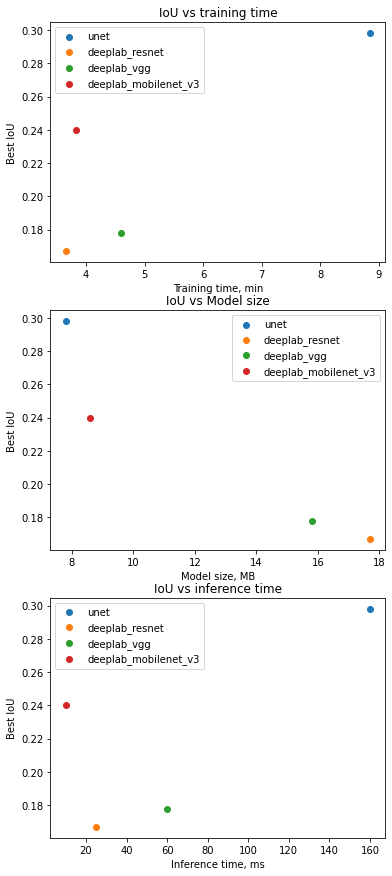

In [8]:
times = {
    'unet': 8.85,
    'deeplab_resnet': 3.65,
    'deeplab_vgg': 4.59,
    'deeplab_mobilenet_v3': 3.83,
}

mIoU = {
    'unet': 0.298,
    'deeplab_resnet': 0.167,
    'deeplab_vgg': 0.178,
    'deeplab_mobilenet_v3': 0.24,
}

model_size = {
    'unet': 7.8,
    'deeplab_resnet': 17.7,
    'deeplab_vgg': 15.8,
    'deeplab_mobilenet_v3': 8.6,
}

inf_time = {
    'unet': 160,
    'deeplab_resnet': 25,
    'deeplab_vgg': 60,
    'deeplab_mobilenet_v3': 10,
}

import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(6, 15))

for model_name in model_size:
    axs[0].scatter(times[model_name], mIoU[model_name], label=model_name)
    axs[0].set_xlabel('Training time, min')
    axs[0].set_ylabel('Best IoU')
    axs[0].set_title('IoU vs training time')
    axs[0].legend()
    
for model_name in model_size:
    axs[1].scatter(model_size[model_name], mIoU[model_name], label=model_name)
    axs[1].set_xlabel('Model size, MB')
    axs[1].set_ylabel('Best IoU')
    axs[1].set_title('IoU vs Model size')
    axs[1].legend()
    
for model_name in model_size:
    axs[2].scatter(inf_time[model_name], mIoU[model_name], label=model_name)
    axs[2].set_xlabel('Inference time, ms')
    axs[2].set_ylabel('Best IoU')
    axs[2].set_title('IoU vs inference time')
    axs[2].legend()
    
plt.savefig('fig.png', format='png')

Model with MobileNetv3 the most efficient in case all cases (on average). Unet is more accurate in case of IoU metric. this is due to the fact that it processes data from all image scales.

#### Task 4.

Pick the best model according to **mIoU** and look at the visualized predictions on the validation set in the TensorBoard. For each segmentation class, find the good examples (if they are available), and the failure cases. Provide the zoomed-in examples and their analysis below. Please do not attach full validation images, only the areas of interest which you should crop manually.

<img src="./semantic_segmentation/report/task4.png"/>

It is important to note that the dataset contains errors in the markup and it is not balanced enough. Here you can see examples of prediction. The model is Unet.

**<font color='red'>Before the submission please:**

*   comment all strings that start with '!' symbol
*   convert your notebook to .py file and check that it runs correctly.
* upload both .ipynb and .py to Canvas


  How to get .py file in Colab: File -> Download -> Download .py</font>

In [ ]:
#Left side menu in Colab -> Files -> Upload your script and then check.
!python hw2_semantic_segmentation_surname_name_attempt_1.py
# comment this block after checking
# You can replace TODO strings to None